# Problem Set #2 
MACS 30100 Dr. Evans

Xiuyuan Zhang

## Question 1
### (a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

In [60]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

income_data = np.loadtxt("incomes.txt")

<IPython.core.display.Javascript object>


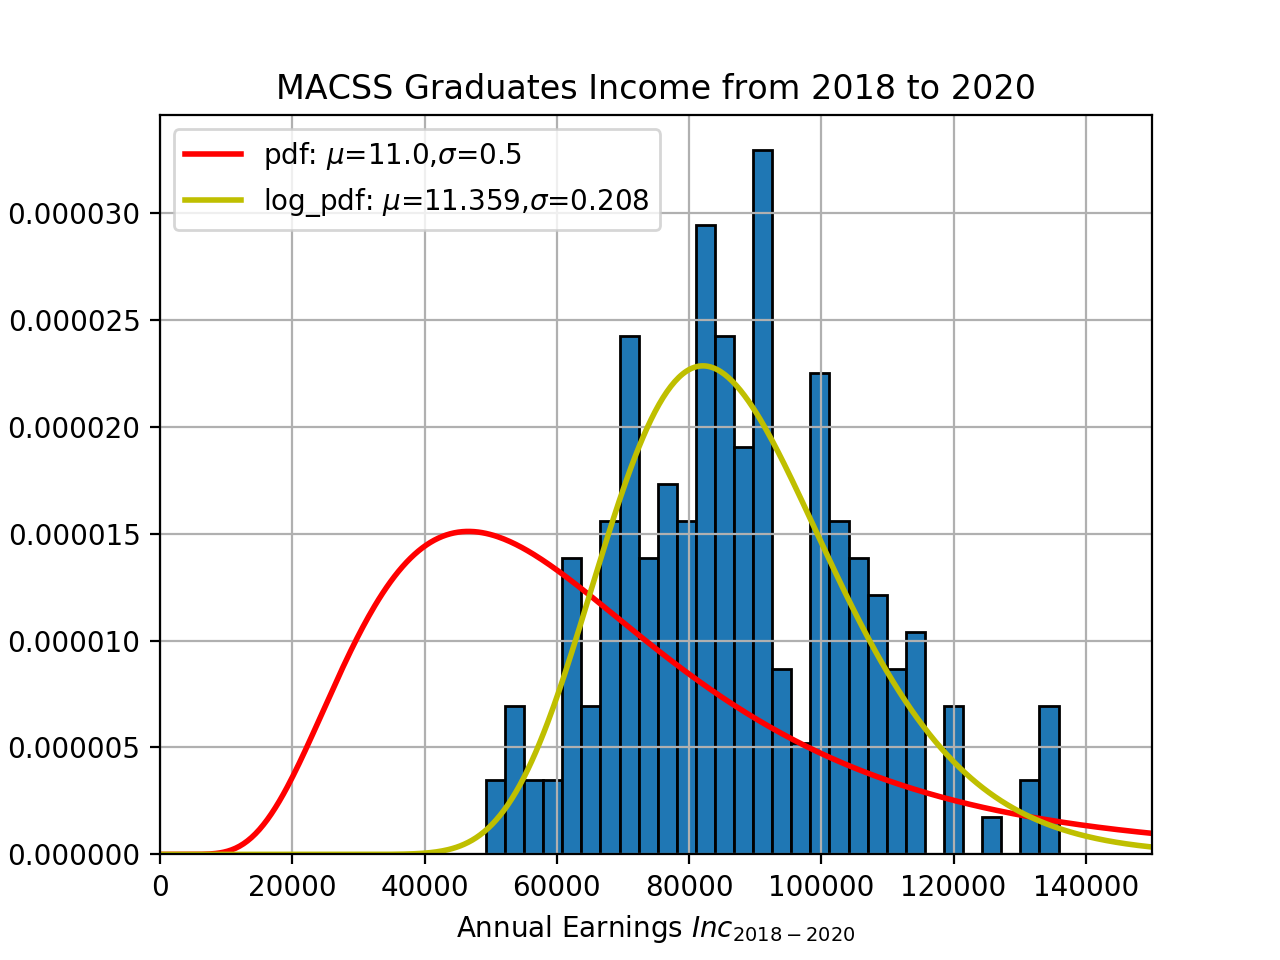

In [61]:
%matplotlib notebook

# plot the histogram for (a)
plt.hist(income_data, bins = 30, edgecolor ='black', normed = True)
plt.xlim(0.01, 150000)

plt.title('MACSS Graduates Income from 2018 to 2020')
plt.ylabel('Percentage')
plt.xlabel('Annual Earnings $Inc_{2018-2020}$')
plt.grid(True)

plt.show()

### (b) Plot the lognormal PDF f(x|μ = 11.0,σ = 0.5) for 0 ≤ x ≤ 150,000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [62]:
def calculate_pdf(xvals, mu, sigma, cutoff):
    '''
    Calculate log normal distribution.
    
    Inputs: xvals(numpy array)
            mu (float): mean
            sigma (float): standard deviation
            cutoff (float): scalar upper bound value of distribution,
                            or None
    Returns: pdf_vals(numpy array)
    '''
    
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                prob_notcut)
    
    return pdf_vals

In [63]:
# plot the distribution for given sigma and mu

dist_pts = np.linspace(0.01, 150000, 500)
plt.plot(dist_pts, calculate_pdf(dist_pts, 11, 0.5, 150000),
         linewidth=2, color='r', label='pdf: $\mu$=11.0,$\sigma$=0.5')
plt.legend(loc='upper left')

In [64]:
def calculate_log_lik(xvals, mu, sigma, cutoff):
    '''
    Calculate log likelihood.
    
    Inputs: xvals(numpy array)
            mu(float): mean
            sigma(float): standard deviation
            cutoff(float): scalar upper bound value of distribution,
                           or None
    Returns: log_pdf_vals(float)
    '''
       
    pdf_vals = calculate_pdf(xvals, mu, sigma, cutoff)
    log_pdf_vals = np.log(pdf_vals).sum()
    
    
    return log_pdf_vals

print('Log-likelihood value for this parameterization of the distribution and given this data is: ',
      calculate_log_lik(income_data, 11.0, 0.5, 150000))

Log-likelihood value for this parameterization of the distribution and given this data is:  -2385.85699781


### (c) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 ≤ x ≤ 150, 000. Report the ML estimates for μ and σ, the value of the likelihood function, and the variance-covariance matrix.

In [65]:
def crit(params, *args):
    '''
    Computes the negative of the log likelihood function
    given parameters and data for minimization.
    
    Inputs: params(list): two floats, mu and sigma
            args(tuple): a numpy array, and the cutoff value
    Returns: neg_log_lik_val(float)
    '''
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = calculate_log_lik(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [66]:
params_init = np.array([11.0, 0.5])
mle_args = (income_data, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds = ((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
log_lik_val = calculate_log_lik(income_data, mu_MLE, sig_MLE, 150000)
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])

print('The ML estimates for mu is', mu_MLE, 'and for sigma is', sig_MLE)
print('')
print('The value of the likelihood function is', log_lik_val)
print('')
print('The variance-covariance matrix is', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

The ML estimates for mu is 11.3590244083 and for sigma is 0.208178530816

The value of the likelihood function is -2241.71930137

The variance-covariance matrix is [[  2.52837320e-04  -2.76193333e-05]
 [ -2.76193333e-05   1.30456624e-04]]
Standard error for mu estimate =  0.0159008591086
Standard error for sigma estimate =  0.0114217609852


In [67]:
# plot part c against part a and b
plt.plot(dist_pts, calculate_pdf(dist_pts, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='y', label='log_pdf: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')

### (d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b).

In [68]:
log_lik_h0 = calculate_log_lik(income_data, 11, 0.5, 1500000)
log_lik_mle = calculate_log_lik(income_data, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('With 2 degrees of freedom, the probablity that the data in income.txt came from the distribution in part b is', pval_h0)

With 2 degrees of freedom, the probablity that the data in income.txt came from the distribution in part b is 0.0


### (e) With your estimated distribution of incomes for Chicago MACSS students from part (c), you now have a model for what your own income might look like when you graduate. Using that estimated model from part (c), What is the probability that you will earn more than \$100,000?  What is the probability that you will earn less than $75,000?

In [69]:
p_100000 = 1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p_75000 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)

print("The probability that one will earn more than $100,000 is", p_100000)
print("")
print("The probability that one will earn more than $75,000 is", p_75000)

The probability that one will earn more than $100,000 is 0.229870198195

The probability that one will earn more than $75,000 is 0.260233280491


# Question 2
### a) Estimate (β0, β1, β2, β3, σ2) to maximize the likelihood of seeing the data in sick.txt. Report your estimates, the value of the log likelihood function, and the estimated variance covariance matrix of the estimates.

In [70]:
# import the data
sick_data = pd.read_csv("sick.txt")

In [71]:
def get_error_sum(ls_param, ls_var):
    '''
    Get error sum of the linear regression model
    Inputs: ls_param: tuple of parameters
            ls_var: tuple of variables
    Return: error_sum
    '''
    age, children, weather, sick = ls_var
    b_0, b_1, b_2, b_3, sigma = ls_param
    error_sum = np.sum((sick - b_0 - b_1 * age - b_2 * children - b_3 * weather) ** 2)
    
    return error_sum

def get_log_lik_2(ls_param, *args):
    '''
    Get the log likelihood value for this linear regression model
    Inputs: ls_param: tuple of parameters
            agrs: variables
    Return: - log_lik_val
    '''
    age, children, weather, sick = args
    b_0, b_1, b_2, b_3, sigma = ls_param
    error_sum = get_error_sum(ls_param, args)
    N = len(age)
    log_lik_val = - N / 2 * np.log(2 * np.pi) - N * np.log(sigma) - 1 / (2 * sigma ** 2)\
                  * error_sum
    return - log_lik_val

# plug in data and calculate
children = sick_data["children"]
weather = sick_data["avgtemp_winter"]
age = sick_data["age"]
sick = sick_data["sick"]
params_guess = (1, 0, 0, 0, 1)

log_lik_val = get_log_lik_2(params_guess, age, children, weather, sick)

result = opt.minimize(get_log_lik_2, params_guess, args = ((age, children, weather, sick)),\
         method = 'L-BFGS-B', bounds = ((0.1, None), (0.01, None), (0.1, None), (None, -0.001),\
                                        (0.001, None)))

OffDiagNeg = np.eye(5)*2 - 1
vcv_2 = result.hess_inv.todense() * OffDiagNeg

print("My estimates are in this order, b_0, b_1, b_2, b_3, sigma:", result.x)
print("")
print("The log likelihood value is",log_lik_val)
print("")
print("The estimated variance covariance matrix of the estimates is:")
print(vcv_mle)


My estimates are in this order, b_0, b_1, b_2, b_3, sigma: [ 0.2516445   0.01293345  0.40050114 -0.00999169  0.00301773]

The log likelihood value is 209.092006641

The estimated variance covariance matrix of the estimates is:
[[  2.52837320e-04  -2.76193333e-05]
 [ -2.76193333e-05   1.30456624e-04]]


### (b) Use a likelihood ratio test to determine the probability that β0 = 1.0, σ2 = 0.01 and β1,β2,β3 = 0. That is, what is the likelihood that age, number of children, and average winter temperature have no effect on the number of sick days?

In [73]:
log_lik_h0_sick = - get_log_lik_2((1.0, 0, 0, 0, 0.1), age, children, weather, sick)
log_lik_mle_sick = - get_log_lik_2((0.2516, 0.0129, 0.4005, -0.0099, 0.0030), age, children, weather, sick)
lr_val = 2 * (log_lik_mle_sick - log_lik_h0_sick)
pval_h0_sick = 1.0 - sts.chi2.cdf(lr_val, 5)
print('Since the likelihood that age, number of children, and average winter temperature have no effect on the number of sick days is:',\
      pval_h0_sick, ', this hypothesis is rejected.')

Since the likelihood that age, number of children, and average winter temperature have no effect on the number of sick days is: 0.0 , this hypothesis is rejected.
